<a href="https://colab.research.google.com/github/KozinIS/CV/blob/main/08_%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F_(CNN_PSPNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Сегментация изображения (CNN PSPNet)**

# 1 Постановка задачи

*Подготовьте свёрточную нейронную сеть PSPNet для сегментации изображений стройки. Добейтесь максимально возможной точности.*

# 2 Подгрузка библиотек и подключение диска

In [ ]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Dense, Dropout # Импортируем стандартные слои keras
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import os # Импортируем библиотеку os для раоты с фаловой системой
from PIL import Image # импортируем модель Image для работы с изображениями
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
from google.colab import drive # Подключаем гугл-диск
drive.mount('/content/drive')

Mounted at /content/drive


# 3 Подгрузка картинок

In [ ]:
# Глобальные параметры
img_width = 176 # Ширина уменьшенной картинки
img_height = 240 # Высота уменьшенной картинки
num_classes = 7 # Задаем количество классов на изображении
directory = '/content/drive/My Drive/HW_25/' # Указываем путь к обучающей выборке с оригинальными изображения
train_directory = 'Тренировочная_стройка' # Название папки с файлами обучающей выборки
val_directory = 'Проверочная_стройка' # Название папки с файлами проверочной выборки

Оригинальные изображения

In [ ]:
train_images = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки
val_images = [] # Создаем пустой список для хранений оригинльных изображений проверочной выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + train_directory+'/Исходники')): # Проходим по всем файлам в каталоге по указанному пути
    train_images.append(image.load_img(os.path.join(directory + train_directory+'/Исходники',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size
print ('Обучающая выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок обучающей выборки
print ('Количество изображений: ', len(train_images)) # Отображаем количество элементов в обучающей выборке

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + val_directory+'/Исходники')): # Проходим по всем файлам в каталоге по указанному пути
    val_images.append(image.load_img(os.path.join(directory + val_directory+'/Исходники',filename),
                                     target_size=(img_width, img_height)))  # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size
print ('Проверочная выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок проверочной выборки
print ('Количество изображений: ', len(val_images)) # Отображаем количество элементов в проверочной выборке

Обучающая выборка загржуена. Время загрузки: 350.65c
Количество изображений:  900
Проверочная выборка загржуена. Время загрузки: 20.03c
Количество изображений:  50


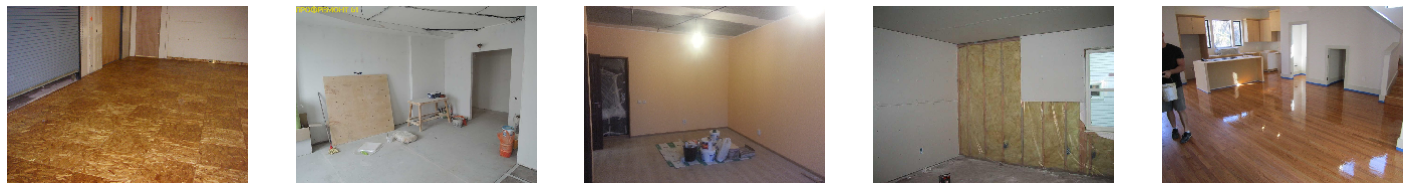

In [ ]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 10)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = random.choice(train_images) # Выбираем случайное фото для отображения
  axs[i].axis('off')
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

Сегментированные изображения

In [ ]:
train_segments = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки
val_segments = [] # Создаем пустой список для хранений оригинльных изображений проверочной выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + train_directory+'/Размеченные')): # Проходим по всем файлам в каталоге по указанному пути
    train_segments.append(image.load_img(os.path.join(directory + train_directory+'/Размеченные',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size
print ('Обучающая выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок обучающей выборки
print ('Количество изображений: ', len(train_segments)) # Отображаем количество элементов в обучающем наборе сегментированных изображений

cur_time = time.time() # Засекаем текущее время
# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(directory + val_directory+'/Размеченные')):
    # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size
    val_segments.append(image.load_img(os.path.join(directory + val_directory+'/Размеченные',filename),
                                     target_size=(img_width, img_height)))  # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size
print ('Проверочная выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок проверочной выборки
print ('Количество изображений: ', len(val_segments)) # Отображаем количество элементов в проверочном наборе сегментированных изображений

Обучающая выборка загржуена. Время загрузки: 355.78c
Количество изображений:  900
Проверочная выборка загржуена. Время загрузки: 20.95c
Количество изображений:  50


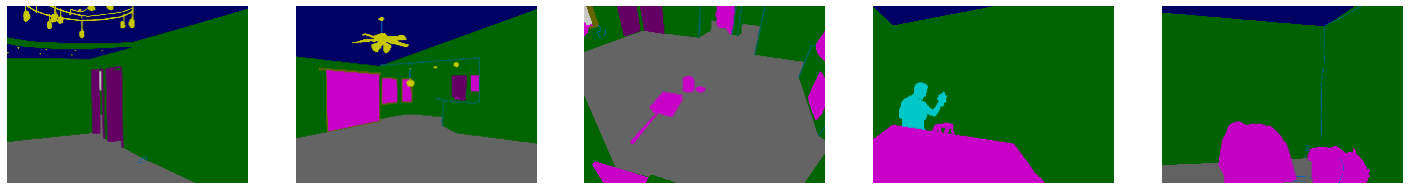

In [ ]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 10)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = random.choice(train_segments) # Выбираем случайное фото для отображения
  axs[i].axis('off')
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

# 4 Формирование обучающей выборки

In [ ]:
# Функция преобразования пикселя сегментированного изображения в индекс (7 классов)
def color2index(color):
  index=-1
  if (149>=color[0]>51)and(149>=color[1]>=51)and(149>=color[2]>=51)       : index=0 # пол
  elif (49>=color[0]>=0)and(49>=color[1]>=0)and(149>=color[2]>=51)        : index=6 # потолок
  elif (49>=color[0]>=0)and(149>=color[1]>=51)and(49>=color[2]>=0)        : index=6 # стена
  elif (149>=color[0]>=51)and(49>=color[1]>=0)and(49>=color[2]>=0)        : index=6 # колонна
  elif (49>=color[0]>=0)and(149>=color[1]>=51)and(149>=color[2]>=51)      : index=6 # проем
  elif (149>=color[0]>=51)and(49>=color[1]>=0)and(149>=color[2]>=51)      : index=6 # дверь
  elif (149>=color[0]>=51)and(149>=color[1]>=51)and(49>=color[2]>=0)      : index=6 # окно
  elif (249>=color[0]>=151)and(249>=color[1]>=151)and(249>=color[2]>=151) : index=1 # внешний мир
  elif (49>=color[0]>=0)and(49>=color[1]>=51)and(249>=color[2]>=151)      : index=6 # лестница
  elif (49>=color[0]>=0)and(249>=color[1]>=151)and(49>=color[2]>=0)       : index=6 # перила
  elif (249>=color[0]>=151)and(49>=color[1]>=0)and(49>=color[2]>=0)       : index=3 # батарея
  elif (49>=color[0]>=0)and(249>=color[1]>=151)and(249>=color[2]>=151)    : index=2 # люди
  elif (249>=color[0]>=151)and(49>=color[1]>=0)and(249>=color[2]>=151)    : index=6 # инвентарь
  elif (249>=color[0]>=151)and(249>=color[1]>=151)and(49>=color[2]>=0)    : index=4 # источники света
  elif (49>=color[0]>=0)and(149>=color[1]>=51)and(249>=color[2]>=151)     : index=6 # провода
  elif (149>=color[0]>=51)and(49>=color[1]>=0)and(249>=color[2]>=151)     : index=6 # балка
  else: index=6
  return index

In [ ]:
# Функция преобразования индекса в цвет пикселя
def index2color(index2):
  index = np.argmax(index2) # Получаем индекс максимального элемента
  color=[]
  if index == 0: color = [100, 100, 100]  # пол
  elif index == 1: color = [0, 0, 100]    # потолок
  elif index == 2: color = [0, 100, 0]    # стена
  elif index == 3: color = [100, 0, 0]    # проем, дверь, окно
  elif index == 4: color = [0, 100, 100]  # колонна, лестница, внешний мир, перила, батарея, инвентарь, источники света, провода, балка
  elif index == 5: color = [100, 0, 100]  # люди
  elif index == 6: color = [0, 0, 0]      # остальное
  return color # Возвращаем цвет пикслея

In [ ]:
# Функция перевода индекса пикслея в to_categorical
def rgbToohe(y, num_classes):
  y2 = y.copy() # Создаем копию входного массива
  y = y.reshape(y.shape[0] * y.shape[1], 3) # Решейпим в двумерный массив
  yt = [] # Создаем пустой лист
  for i in range(len(y)): # Проходим по всем трем канала изображения
    yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) # Переводим пиксели в индексы и преобразуем в OHE
  yt = np.array(yt) # Преобразуем в numpy
  yt = yt.reshape(y2.shape[0], y2.shape[1], num_classes) # Решейпим к исходныму размеру
  return yt # Возвращаем сформированный массив

In [ ]:
# Функция формирования yTrain
def yt_prep(data, num_classes):
  yTrain = [] # Создаем пустой список под карты сегметации
  for seg in data: # Пробегаем по всем файлам набора с сегминтированными изображениями
    y = image.img_to_array(seg) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    y = rgbToohe(y, num_classes) # Получаем OHE-представление сформированного массива
    yTrain.append(y) # Добавляем очередной элемент в yTrain
    if len(yTrain) % 100 == 0: # Каждые 100 шагов
      print(len(yTrain)) # Выводим количество обработанных изображений
  return np.array(yTrain) # Возвращаем сформированный yTrain

In [ ]:
xTrain = [] # Создаем пустой список под обучающую выборку
for img in train_images: # Проходим по всем изображениям из train_images
  x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
  xTrain.append(x) # Добавляем очередной элемент в xTrain
xTrain = np.array(xTrain) # Переводим в numpy

xVal = [] # Создаем пустой список под проверочную выборку
for img in val_images: # Проходим по всем изображениям из val_images
  x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
  xVal.append(x) # Добавляем очередной элемент в xTrain
xVal = np.array(xVal) # Переводим в numpy

print(xTrain.shape) # Размерность обучающей выборки
print(xVal.shape) # Размерность проверочной выборки

(900, 176, 240, 3)
(50, 176, 240, 3)


In [ ]:
cur_time = time.time() # Засекаем текущее время
yTrain = yt_prep(train_segments, num_classes)  # Создаем yTrain
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы

100
200
300
400
500
600
700
800
900
Время обработки:  1276.3 c


In [ ]:
cur_time = time.time() # Засекаем текущее время
yVal = yt_prep(val_segments, num_classes) # Создаем yVal
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы

Время обработки:  68.63 c


In [ ]:
yTrain.shape

(900, 176, 240, 7)

# 5 Создание и обучение нейросети

## 5.1 Создание нейросети

In [ ]:
# Функция визуализации сегментированных изображений
def processImage(model, count = 1, n_classes = 6):
  indexes = np.random.randint(0, len(xVal), count) # Получаем count случайных индексов
  fig, axs = plt.subplots(3, count, figsize=(25, 15)) #Создаем полотно из n графиков
  for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
    predict = np.array(model.predict(xVal[idx].reshape(1, img_width, img_height, 3))) # Предиктим картику
    pr = predict[0] # Берем нулевой элемент из перидкта
    pr1 = [] # Пустой лист под сегментированную картинку из predicta
    pr2 = [] # Пустой лист под сегменитрованную картинку из yVal
    pr = pr.reshape(-1, n_classes) # Решейпим предикт
    yr = yVal[idx].reshape(-1, n_classes) # Решейпим yVal
    for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
      pr1.append(index2color(pr[k])) # Переводим индекс в писксель
      pr2.append(index2color(yr[k])) # Переводим индекс в писксель
    pr1 = np.array(pr1) # Преобразуем в numpy
    pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
    pr2 = np.array(pr2) # Преобразуем в numpy
    pr2 = pr2.reshape(img_width, img_height,3) # Решейпим к размеру изображения
    img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
    axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
    axs[0,i].axis('off')
    axs[1,i].imshow(Image.fromarray(pr2.astype('uint8'))) # Отображаем на графике во второй линии сегментированное изображение из yVal
    axs[1,i].axis('off')
    axs[2,i].imshow(Image.fromarray(xVal[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение
    axs[2,i].axis('off')
  plt.show()

In [ ]:
def PSPNet(num_classes = 3, input_shape= (88, 120, 3)):
    img_input = Input(input_shape)

    # Block 1:
    L1 = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    L1 = BatchNormalization()                                   (L1)
    L1 = Activation('relu')                                     (L1)

    L1 = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(L1)
    L1 = BatchNormalization()                                   (L1)
    L1_out = Activation('relu')                                 (L1)

    # Blocks 2:
    L2_1 = MaxPooling2D(4)                 (L1_out)
    L2_1 = Dropout (0.3)                   (L2_1)
    L2_1 = Dense (32, activation = 'relu') (L2_1)

    L2_2 = MaxPooling2D(2)                 (L1_out)
    L2_2 = Dropout (0.3)                   (L2_2)
    L2_2 = Dense (32, activation = 'relu') (L2_2)

    # Blocks 3:
    L3_1 = Conv2DTranspose(8, (2, 2), strides=(4, 4), padding='same')(L2_1)
    L3_2 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(L2_2)

    # Concatenate:
    L4 = concatenate([L3_1, L3_2, L1_out])
    L4 = Conv2D(64, (3, 3), padding='same') (L4)
    L4 = BatchNormalization()               (L4)
    L4 = Activation('relu')                 (L4)

    L4 = Conv2D(64, (3, 3), padding='same') (L4)
    L4 = BatchNormalization()               (L4)
    L4 = Activation('relu')                 (L4)

    L4 = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')  (L4)

    model = Model(img_input, L4)

    # Компилируем модель
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])

    return model # Возвращаем сформированную модель

In [ ]:
modelPSPNet = PSPNet(num_classes, (img_width, img_height, 3))

In [ ]:
modelPSPNet.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 176, 240, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 176, 240, 64) 1792        input_17[0][0]                   
__________________________________________________________________________________________________
batch_normalization_61 (BatchNo (None, 176, 240, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_61 (Activation)      (None, 176, 240, 64) 0           batch_normalization_61[0][0]     
______________________________________________________________________________________

Функция метрики, обрабатывающая пересечение двух областей

In [ ]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

## 5.2 Обучение нейросети

In [ ]:
history = modelPSPNet.fit(xTrain, yTrain, epochs=90, batch_size=32, validation_data = (xVal, yVal)) # Обучаем модель на выборке по трем классам

Epoch 1/90
29/29 [==============================] - 5s 157ms/step - loss: 0.8710 - dice_coef: 0.5617 - val_loss: 8.4268 - val_dice_coef: 0.0611
Epoch 2/90
29/29 [==============================] - 4s 145ms/step - loss: 0.6585 - dice_coef: 0.6462 - val_loss: 4.2330 - val_dice_coef: 0.1052
Epoch 3/90
29/29 [==============================] - 4s 146ms/step - loss: 0.6332 - dice_coef: 0.6487 - val_loss: 2.3383 - val_dice_coef: 0.1930
Epoch 4/90
29/29 [==============================] - 4s 145ms/step - loss: 0.6179 - dice_coef: 0.6578 - val_loss: 1.4101 - val_dice_coef: 0.3253
Epoch 5/90
29/29 [==============================] - 4s 145ms/step - loss: 0.6113 - dice_coef: 0.6674 - val_loss: 1.4302 - val_dice_coef: 0.3837
Epoch 6/90
29/29 [==============================] - 4s 147ms/step - loss: 0.6004 - dice_coef: 0.6671 - val_loss: 1.0512 - val_dice_coef: 0.4600
Epoch 7/90
29/29 [==============================] - 4s 146ms/step - loss: 0.5931 - dice_coef: 0.6735 - val_loss: 1.1833 - val_dice_coef:

In [ ]:
#modelUnet.save_weights('/content/drive/My Drive/Занятия/Февральский курс/Занятие 14/modelUnet.h5')

# 6 Результаты (проверка работы нейросети через распознование)

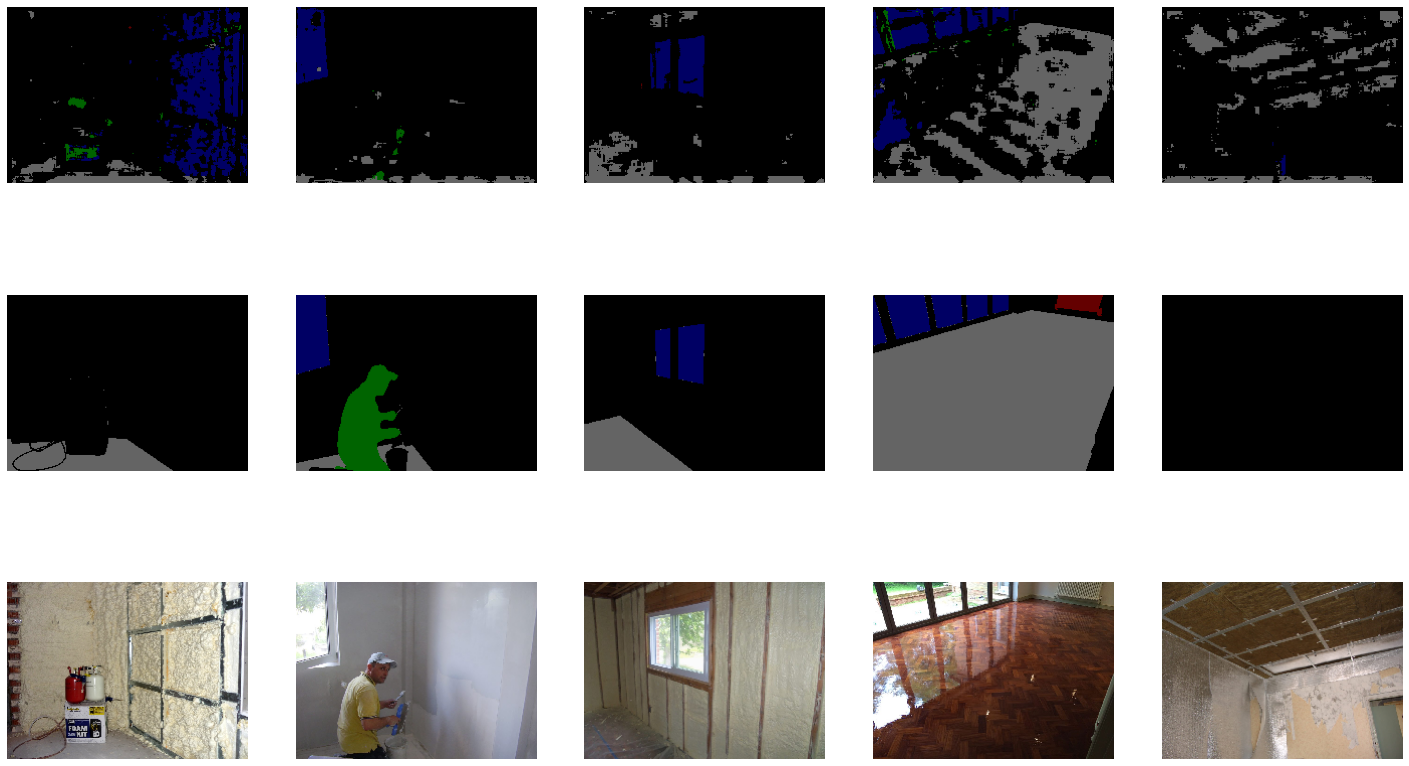

In [ ]:
processImage(modelPSPNet, 5, num_classes)

# 7 Выводы

Создана и обучена свёрточная нейронная сеть, основвнная на архитектуре PSPNET и предназначенная для сегментирования изображения (фотографий строительных работ).

Проверка результатов работы нейронной сети сегментированием конкретных картинок домонстрирует её жизнеспособность. Для повышения точности работы нейронной сети представляется целесообразным провести эксперименты, связанные с :
- внесением изменений в архитектуру нейронной сети;
- увеличением эпох обучения.